In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
! jupyter nbextension enable --py widgetsnbextension
np.set_printoptions(suppress=True)

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


<h1>Section 0/1 - Data Exploration/Building Probability Distributions</h1>

Just looking at the data and seeing what's doing on. Here is some stuff I found about the csv files.

<h4>atbats.csv</h4>

- <code>pitcher_id</code>: This has the pitcher id. In the player_names.csv, this is the <code>id</code> column.
- <code>batter_id</code>: This has the batter id. In the player_names.csv, this is the <code>id</code> column.
- <code>ab_id</code>: This is the id of the at bat. In the pitches.csv, this is the <code>ab_id</code> column.
- <code>g_id</code>: This is the id of the game.

<h4>Read in the data</h4>

In [2]:
# Read in data
pitches = pd.read_csv('csv_data/pitches.csv')
names = pd.read_csv('csv_data/player_names.csv')
at_bat = pd.read_csv('csv_data/atbats.csv')
games = pd.read_csv('csv_data/games.csv')

# Read in more recent data.
pitches_2019 = pd.read_csv('csv_data/2019_pitches.csv')
atbats_2019 = pd.read_csv('csv_data/2019_atbats.csv')
games_2019 = pd.read_csv('csv_data/2019_games.csv')

# Drop necessary columns to be able to stack data.
games.drop(columns=['delay'], inplace=True)

# Stack dataframes together.
print(f'pitches.shape {pitches.shape}, at_bat.shape {at_bat.shape}, games.shape {games.shape}')
pitches = pd.concat([pitches, pitches_2019], ignore_index=True, axis=0)
at_bat = pd.concat([at_bat, atbats_2019], ignore_index=True, axis=0)
games = pd.concat([games, games_2019], ignore_index=True, axis=0)
print(f'pitches.shape {pitches.shape}, at_bat.shape {at_bat.shape}, games.shape {games.shape}')

# Create column in names with full name.
names['full_name'] = names['first_name'] + ' ' + names['last_name']

pitches.shape (2867154, 40), at_bat.shape (740389, 11), games.shape (9718, 16)
pitches.shape (3595944, 40), at_bat.shape (925634, 11), games.shape (12126, 16)


<h4>Merge the data to get pitcher_id/full_name linked up with the pitches they threw</h4>

In [92]:
# Merge pitches and at_bats together.
pitches_merge = pitches.merge(at_bat, on='ab_id', validate='m:1')

# Merge pitches_merge and names together
pitches_merge = pitches_merge.merge(names, left_on='pitcher_id', right_on='id')
pitches_merge.drop(['last_name', 'first_name'], axis=1, inplace=True)
pitches_merge.set_index('pitcher_id', inplace=True)

(3595944, 50)
(3596799, 55)


,px,pz,start_speed,end_speed,spin_rate,spin_dir,break_angle,break_length,break_y,ax,...,inning,o,p_score,p_throws,pitcher_id,stand,top,id,full_name,_merge
3513475,-0.23,1.85,94.6,87.5,placeholder,placeholder,28.8,7.2,24.0,-18.45,...,8.0,1.0,12.0,R,592165.0,R,1.0,NaN,NaN,left_only
3513476,0.36,2.33,95.3,87.2,placeholder,placeholder,33.6,7.2,24.0,-20.70,...,8.0,1.0,12.0,R,592165.0,L,1.0,NaN,NaN,left_only
3513477,-0.57,1.41,95.2,86.9,placeholder,placeholder,39.6,7.2,24.0,-23.85,...,8.0,1.0,12.0,R,592165.0,L,1.0,NaN,NaN,left_only
3513478,-0.50,0.59,85.7,78.8,placeholder,placeholder,30.0,8.4,24.0,-16.32,...,8.0,1.0,12.0,R,592165.0,L,1.0,NaN,NaN,left_only
3513479,-0.87,1.65,84.4,77.6,placeholder,placeholder,28.8,8.4,24.0,-17.74,...,8.0,1.0,12.0,R,592165.0,L,1.0,NaN,NaN,left_only
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3596794,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,582473.0,Sherman Johnson,right_only
3596795,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,664702.0,Myles Straw,right_only
3596796,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,624641.0,Edmundo Sosa,right_only
3596797,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,605612.0,Harold Castro,right_only


<h4>Save <code>pitches_merge</code> as parquet file (for ease of reloading)</h4>

In [81]:
# The column spin_rate has value 'placeholder' for 641k rows. Convert those all to 0.
pitches_merge['spin_rate'] = pitches_merge.spin_rate.replace('placeholder', 0)
pitches_merge['spin_dir'] = pitches_merge.spin_dir.replace('placeholder', 0)
pitches_merge['type_confidence'] = pitches_merge.type_confidence.replace('placeholder', 0)
pitches_merge['zone'] = pitches_merge.zone.replace('placeholder', 0)
pitches_merge['x'] = pd.to_numeric(pitches_merge['x'], errors='coerce')
pitches_merge['y'] = pd.to_numeric(pitches_merge['y'], errors='coerce')
pitches_merge['code'] = pitches_merge.code.astype(str)
pitches_merge['type'] = pitches_merge.type.astype(str)
pitches_merge['top'] = pitches_merge.top.replace({1.0: True, 0.0: False})

# Convert to parquet.
pitches_merge.to_parquet('pitches_data.parquet')

<h4>Create json file of pitchers full_name and their pitch distribution</h4>

In [20]:
# Get all possible unique pitchers
all_pitchers = pitches_merge.full_name.unique().tolist()

# Create variables
pitch_distributions = dict()

# Iterate through all unique pitchers, getting their distribution of pitches (set up like json). Will look like this:
# {'name': 
#         {'pitch_keys': [keys corresponding to pitches],
#          'pitch_dist' : [distribution of pitches (same order as keys)]}
# }
# Iterate through all pitchers
for pitch in all_pitchers:
    # Get a pitcher subset
    subset = pitches_merge.loc[pitches_merge.full_name == pitch]

    # Get the distribution
    dist = subset['pitch_type'].value_counts() / np.sum(subset['pitch_type'].value_counts())

    # Create the inner dictionary (pitch_keys and pitch_dist) and add it to main dictionary with the key as the pitchers name.
    pitch_distributions[pitch] = {'pitch_keys': dist.index.tolist(), 'pitch_dist' : dist.values.tolist()}

<h4>(View <code>pitch_distributions</code> as a json file for funsies)</h4>

(and save it as a json file)

In [21]:
# j = json.load([pitch_distributions])
j = json.dumps(pitch_distributions, indent=4)[:403]

with open("pitcher_distribution.json", "w") as outfile:
    json.dump(pitch_distributions, outfile)
print(j)

{
    "Jon Lester": {
        "pitch_keys": [
            "FF",
            "FC",
            "CU",
            "SI",
            "CH",
            "PO"
        ],
        "pitch_dist": [
            0.41672005124919925,
            0.2591287636130685,
            0.14433055733504163,
            0.10147341447789879,
            0.07815502882767457,
            0.00019218449711723255
        ]
    },


<h4>Figuring out how to randomly select from distributions</h4>

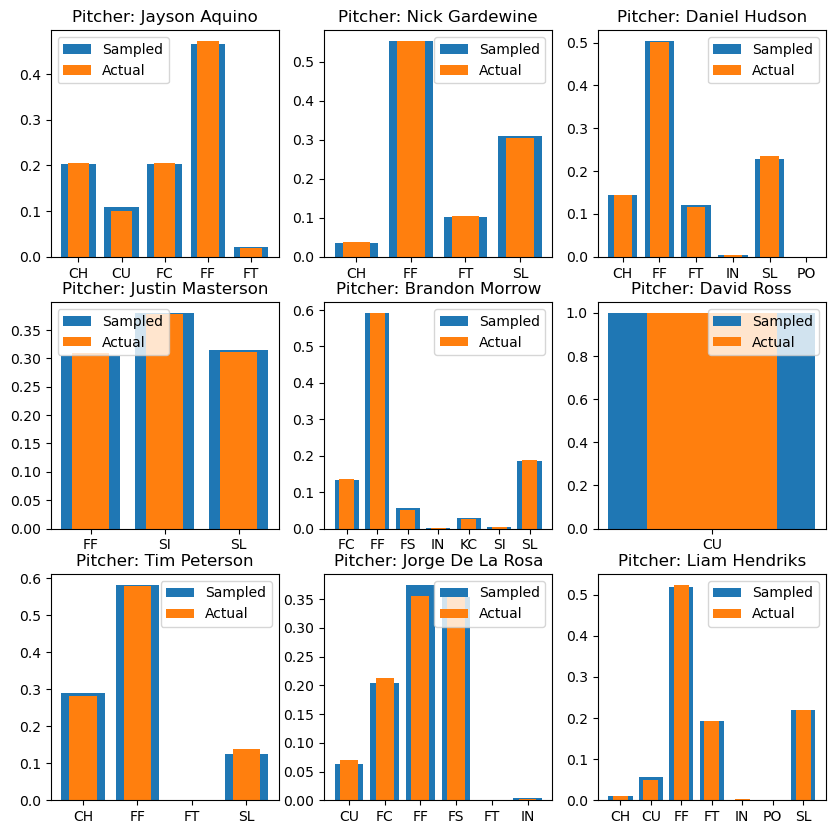

In [93]:
list_of_pitchers = list(pitch_distributions.keys())

# Initilize subplots for better viewing.
rows, cols = 3, 3
fig, ax = plt.subplots(rows, cols, figsize=(10,10), dpi=100)
r, c = 0, 0
for i in range(rows*cols):
    # Randomly select a pitcher
    randomly_selected_pitcher = np.random.choice(list_of_pitchers)

    # Get that pitchers distribution.
    randomly_selected_pitch = np.random.choice(pitch_distributions[randomly_selected_pitcher]['pitch_keys'], 
                                            p=pitch_distributions[randomly_selected_pitcher]['pitch_dist'],
                                            size=2500)

    # To ensure that things are working the way they are supposed to, randomly sample pitch types a ton and make sure the law
    # of large numbers kicks in.
    vals, counts = np.unique(randomly_selected_pitch, return_counts=True)
    ax[r, c].bar(vals, counts/np.sum(counts), label='Sampled')
    ax[r, c].bar(pitch_distributions[randomly_selected_pitcher]['pitch_keys'],
            pitch_distributions[randomly_selected_pitcher]['pitch_dist'],
            width=0.5, label='Actual')
    ax[r,c].legend()
    ax[r,c].set_title(f'Pitcher: {randomly_selected_pitcher}')

    c += 1
    if c == cols:
        r += 1
        c = 0

plt.show()


<h1>Section 2 - CatBoost Baseline</h1>

The first thing we need to do is figure out what data will be the most helpful when determining what pitch might come next. This should be stuff that the hitter has access to, so things like outs, on_1b, etc, but not stuff like spin rate. (The <code>pitches_merge</code> dataframe has just about everything.) Here is a list of potentially important features:

- FROM pitches.csv
    - b_score: This is the score for the batters team.
    - b_count: Number of balls in the at bat.
    - s_count: Number of strikes in the at bat.
    - outs: Number of outs in the inning.
    - pitch_num: Number of pitches in the at bat.
    - on_1b: Whether or not there is a runner on first base.
    - on_2b: Whether or not there is a runner on second base.
    - on_3b: Whether or not there is a runner on third base.
- FROM atbats.csv
    - batter_id: The id of the batter.
    - event: This is what the result of the previous at bat was (single, groundout, strikeout, etc). It could be good to know the result of the previous at bat.
    - inning: What inning the at bat is in.
    - outs: Number of outs in the inning AFTER the current at bat.
    - p_score: This is the score for the pitchers team.
    - p_throws: Whether the pitcher throws left or right handed.
    - stand: Whether the batter bats left or right handed.
        - These two could have a pretty strong correlation with pitch type?
    - top: Whether the team is the home team or not.
- FROM games.csv
    - wind: The wind in mph and the direction (may be useful?).
    - weather: The weather at the game (may be useful?).


In [3]:
# Create a list of columns to keep before merging everything together.
columns_to_keep = ['full_name', 'b_score', 'b_count', 's_count', 'current_outs', 'pitch_num', 'on_1b', 'on_2b', 'on_3b',
                   'batter_id', 'inning', 'p_score', 'p_throws', 'stand', 'top', 'g_id',
                   'pitch_type']

# Merge pitches and atbats
pitches.rename(columns={'outs': 'current_outs'}, inplace=True)
catboost_df = pitches.merge(at_bat, on='ab_id', validate='m:1')
print(f'catboost_df.shape: {catboost_df.shape}')

# Merge pitches_merge and names together
catboost_df = catboost_df.merge(names, left_on='pitcher_id', right_on='id')
catboost_df.drop(['last_name', 'first_name'], axis=1, inplace=True)
print(f'catboost_df.shape: {catboost_df.shape}')

# Merge catboost_df and games
catboost_df = catboost_df.merge(games, on='g_id')
print(f'catboost_df.shape: {catboost_df.shape}')

# Keep only the columns I want to plug into catboost
catboost_df = catboost_df[columns_to_keep]
print(f'catboost_df.shape: {catboost_df.shape}')

# Rename a few columns
catboost_df.rename(columns={'stand': 'batter_stance'}, inplace=True)

# These columns are objects that are actually int64's. Convert to string to run in the algorithm.
catboost_df[['p_throws', 'batter_stance']] = catboost_df[['p_throws', 'batter_stance']].astype('string')
catboost_df[['p_throws', 'batter_stance']] = catboost_df[['p_throws', 'batter_stance']].replace({'R': 'Right', 'L': 'Left'})
catboost_df['top'] = catboost_df.top.replace({1.0: True, 0.0: False})

catboost_df.to_parquet('catboost_data.parquet')
catboost_df.head(5)

catboost_df.shape: (3595944, 50)
catboost_df.shape: (3514339, 52)
catboost_df.shape: (3514339, 67)
catboost_df.shape: (3514339, 17)


,full_name,b_score,b_count,s_count,current_outs,pitch_num,on_1b,on_2b,on_3b,batter_id,inning,p_score,p_throws,batter_stance,top,g_id,pitch_type
0,Jon Lester,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,572761,1.0,0.0,Left,Left,True,201500001.0,FF
1,Jon Lester,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,572761,1.0,0.0,Left,Left,True,201500001.0,FF
2,Jon Lester,0.0,0.0,2.0,0.0,3.0,0.0,0.0,0.0,572761,1.0,0.0,Left,Left,True,201500001.0,FF
3,Jon Lester,0.0,0.0,2.0,0.0,4.0,0.0,0.0,0.0,572761,1.0,0.0,Left,Left,True,201500001.0,FF
4,Jon Lester,0.0,1.0,2.0,0.0,5.0,0.0,0.0,0.0,572761,1.0,0.0,Left,Left,True,201500001.0,CU


In [5]:
# We only want to keep pitch_type_shift, so drop pitch_type
### This may be something we might want to include next time.
# catboost_df.drop(columns='pitch_type', inplace=True)
catboost_df = pd.read_parquet('catboost_data.parquet')
X = catboost_df.iloc[:, :-1]
y = catboost_df.iloc[:, -1]
print(f'X.shape, y.shape : {X.shape}, {y.shape}')

X.shape, y.shape : (3514339, 15), (3514339,)


In [20]:
# Split our data
X_train, X_val, y_train, y_val = train_test_split(
	X, y, test_size=0.25, random_state=28)

# Define the hyperparameters for the CatBoost algorithm
# params = {'learning_rate': 0.1, 
#           'depth': 6,
# 		  'l2_leaf_reg': 3,
#           'iterations': 25}
    # Best iteration 24, Best test 1.507
params = {'learning_rate': 0.05, 
          'depth': 7,
		  'l2_leaf_reg': 4,
          'iterations': 30}

# Get indicies where column data types are not floats.
categorical_features_indices = [i for i, dtype in enumerate(X.dtypes) if dtype not in (float, int)]

# Initialize the CatBoostClassifier object
# with the defined hyperparameters and fit it on the training set
model = CatBoostClassifier(**params)
# model.fit(X_train, y_train, cat_features=categorical_features_indices, eval_set=(X_val, y_val), save_snapshot=True, 
#           snapshot_file='catboost_snapshot/', snapshot_interval=6, verbose=True)

model.fit(X_train, y_train, cat_features=categorical_features_indices, eval_set=(X_val, y_val), verbose=True)



0:	learn: 2.8057517	test: 2.8058269	best: 2.8058269 (0)	total: 21.7s	remaining: 10m 30s


: 

In [11]:
prediction = model.predict(X_val)
print(model.score(X_val, y_val))

0.4504993825298634


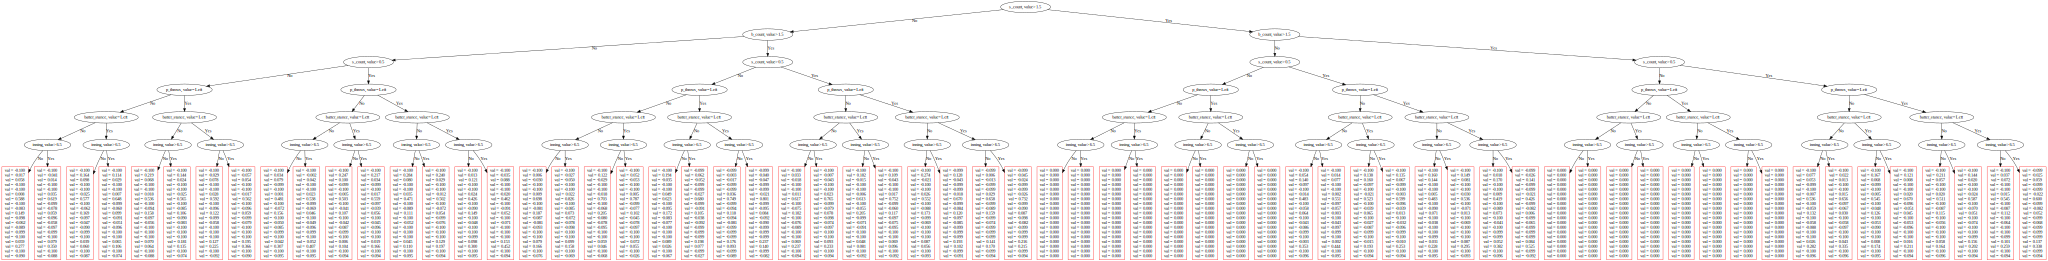

In [16]:

pool = Pool(X_train, y_train, cat_features=categorical_features_indices, feature_names=list(X_train.columns))
model.plot_tree(0, pool=pool)

In [19]:
# print(X_train.columns)
# model.feature_importances_
for col, feat in zip(X_train.columns, model.feature_importances_):
    print(f"{col}: {feat}")

full_name: 84.45465839811291
b_score: 0.20346635979441083
b_count: 2.2251850608916675
s_count: 1.7137891165297572
current_outs: 0.18675025267548306
pitch_num: 0.6598745273173636
on_1b: 0.0
on_2b: 0.0
on_3b: 0.0
batter_id: 0.0
inning: 1.5574827070476174
p_score: 0.0020124876038659515
p_throws: 4.457412817846063
batter_stance: 4.539368272180827
top: 0.0
